In [22]:
!pip install unzip

ERROR: Could not find a version that satisfies the requirement unzip (from versions: none)
ERROR: No matching distribution found for unzip


In [23]:
'''
#Import PyTorch if using Google Colab
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch
'''

"\n#Import PyTorch if using Google Colab\n# http://pytorch.org/\nfrom os.path import exists\nfrom wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag\nplatform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())\ncuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\\.\\([0-9]*\\)\\.\\([0-9]*\\)$/cu\x01\x02/'\naccelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'\n\n!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision\nimport torch\n"

In [24]:
'''
#Check PIL version if using Colab. If below 5.3, restart runtime and run again.
import PIL
print(PIL.PILLOW_VERSION)
'''

'\n#Check PIL version if using Colab. If below 5.3, restart runtime and run again.\nimport PIL\nprint(PIL.PILLOW_VERSION)\n'

In [25]:
#Run this cell to download the Udacity flower set
!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!unzip -qq flower_data.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [26]:
# Import resources
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import time
import json
import copy

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import PIL

from PIL import Image
from collections import OrderedDict


import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F

import os

In [27]:
# check if GPU is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('Bummer!  Training on CPU ...')
else:
    print('You are good to go!  Training on GPU ...')

You are good to go!  Training on GPU ...


In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [29]:
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

In [30]:
# Define your transforms for the training and testing sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])
}

# Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}

# Using the image datasets and the trainforms, define the dataloaders
batch_size = 64
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}

class_names = image_datasets['train'].classes

In [31]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

In [32]:
print(dataset_sizes)
print(device)

{'train': 6552, 'valid': 818}
cuda:0


In [33]:
# Label mapping
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [34]:
# Run this to test the data loader
images, labels = next(iter(dataloaders['train']))
images.size()

torch.Size([64, 3, 224, 224])

In [35]:
# # Run this to test your data loader
images, labels = next(iter(dataloaders['train']))
rand_idx = np.random.randint(len(images))
# print(rand_idx)
print("label: {}, class: {}, name: {}".format(labels[rand_idx].item(),
                                               class_names[labels[rand_idx].item()],
                                               cat_to_name[class_names[labels[rand_idx].item()]]))

label: 90, class: 89, name: watercress


In [36]:
model_name = 'densenet' #vgg
if model_name == 'densenet':
    model = models.densenet161(pretrained=True)
    num_in_features = 2208
    print(model)
elif model_name == 'vgg':
    model = models.vgg19(pretrained=True)
    num_in_features = 25088
    print(model.classifier)
else:
    print("Unknown model, please choose 'densenet' or 'vgg'")

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to C:\Users\virat/.cache\torch\checkpoints\densenet161-8d451a50.pth



DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (re

In [37]:
# Create classifier
for param in model.parameters():
    param.requires_grad = False

def build_classifier(num_in_features, hidden_layers, num_out_features):
   
    classifier = nn.Sequential()
    if hidden_layers == None:
        classifier.add_module('fc0', nn.Linear(num_in_features, 102))
    else:
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        classifier.add_module('fc0', nn.Linear(num_in_features, hidden_layers[0]))
        classifier.add_module('relu0', nn.ReLU())
        classifier.add_module('drop0', nn.Dropout(.6))
        classifier.add_module('relu1', nn.ReLU())
        classifier.add_module('drop1', nn.Dropout(.5))
        for i, (h1, h2) in enumerate(layer_sizes):
            classifier.add_module('fc'+str(i+1), nn.Linear(h1, h2))
            classifier.add_module('relu'+str(i+1), nn.ReLU())
            classifier.add_module('drop'+str(i+1), nn.Dropout(.5))
        classifier.add_module('output', nn.Linear(hidden_layers[-1], num_out_features))
        
    return classifier

In [38]:
hidden_layers = None#[4096, 1024, 256][512, 256, 128]

classifier = build_classifier(num_in_features, hidden_layers, 102)
print(classifier)

 # Only train the classifier parameters, feature parameters are frozen
if model_name == 'densenet':
    model.classifier = classifier
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adadelta(model.parameters()) # Adadelta #weight optim.Adam(model.parameters(), lr=0.001, momentum=0.9)
    #optimizer_conv = optim.SGD(model.parameters(), lr=0.0001, weight_decay=0.001, momentum=0.9)
    sched = optim.lr_scheduler.StepLR(optimizer, step_size=4)
elif model_name == 'vgg':
    model.classifier = classifier
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)
    sched = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
else:
    pass

Sequential(
  (fc0): Linear(in_features=2208, out_features=102, bias=True)
)


In [39]:
# Adapted from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def train_model(model, criterion, optimizer, sched, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        #sched.step()
                        loss.backward()
                        
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    #load best model weights
    model.load_state_dict(best_model_wts)
    
    return model

In [41]:
device

device(type='cuda', index=0)

In [42]:
epochs = 1
model.to(device)
model = train_model(model, criterion, optimizer, sched, epochs)

Epoch 1/1
----------
train Loss: 0.8279 Acc: 0.8437
valid Loss: 0.4168 Acc: 0.9205

Training complete in 1m 1s
Best val Acc: 0.920538


In [43]:
# Evaluation

model.eval()

accuracy = 0

for inputs, labels in dataloaders['valid']:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    
    # Class with the highest probability is our predicted class
    equality = (labels.data == outputs.max(1)[1])

    # Accuracy is number of correct predictions divided by all predictions
    accuracy += equality.type_as(torch.FloatTensor()).mean()
    
print("Test accuracy: {:.3f}".format(accuracy/len(dataloaders['valid'])))

Test accuracy: 0.920


In [44]:
# Saving the checkpoint
model.class_to_idx = image_datasets['train'].class_to_idx

In [45]:
checkpoint = {'input_size': 2208,
              'output_size': 102,
              'epochs': epochs,
              'batch_size': 64,
              'model': models.densenet161(pretrained=True),
              'classifier': classifier,
              'scheduler': sched,
              'optimizer': optimizer.state_dict(),
              'state_dict': model.state_dict(),
              'class_to_idx': model.class_to_idx
             }
   
torch.save(checkpoint, 'checkpoint_final.pth')

In [46]:
# Loading the checkpoint
ckpt = torch.load('checkpoint_final.pth')
ckpt.keys()

dict_keys(['input_size', 'output_size', 'epochs', 'batch_size', 'model', 'classifier', 'scheduler', 'optimizer', 'state_dict', 'class_to_idx'])

In [47]:
'''
# If you are uploading this to the Udacity Lab, you may need this cell
import torch
from torch import optim
from torch.optim import lr_scheduler
from torchvision import models
from collections import namedtuple
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler

import time
import json
import copy

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import PIL

from PIL import Image
from collections import OrderedDict

import os


# If you used something other than 224x224 cropped images, set the correct size here
image_size = 224
# Values you used for normalizing the images. Default here are for
# pretrained models from torchvision.
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]
'''

'\n# If you are uploading this to the Udacity Lab, you may need this cell\nimport torch\nfrom torch import optim\nfrom torch.optim import lr_scheduler\nfrom torchvision import models\nfrom collections import namedtuple\nfrom torch import nn\nimport torch.nn.functional as F\nfrom torch.autograd import Variable\nfrom torchvision import datasets, models, transforms\nfrom torch.utils.data.sampler import SubsetRandomSampler\n\nimport time\nimport json\nimport copy\n\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nimport numpy as np\nimport PIL\n\nfrom PIL import Image\nfrom collections import OrderedDict\n\nimport os\n\n\n# If you used something other than 224x224 cropped images, set the correct size here\nimage_size = 224\n# Values you used for normalizing the images. Default here are for\n# pretrained models from torchvision.\nnorm_mean = [0.485, 0.456, 0.406]\nnorm_std = [0.229, 0.224, 0.225]\n'

In [48]:
# Load a checkpoint and rebuild the model
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    optimizer = checkpoint['optimizer']
    epochs = checkpoint['epochs']
    
    for param in model.parameters():
        param.requires_grad = False
        
    return model, checkpoint['class_to_idx']

In [49]:
model, class_to_idx = load_checkpoint('checkpoint_final.pth')
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [50]:
idx_to_class = { v : k for k,v in class_to_idx.items()}

## Inference for Classification
### Image Preprocessing

In [51]:
image_path = 'flower_data/valid/102/image_08006.jpg'
img = Image.open(image_path)

In [52]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # Process a PIL image for use in a PyTorch model
    # tensor.numpy().transpose(1, 2, 0)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])
    image = preprocess(image)
    return image

In [53]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

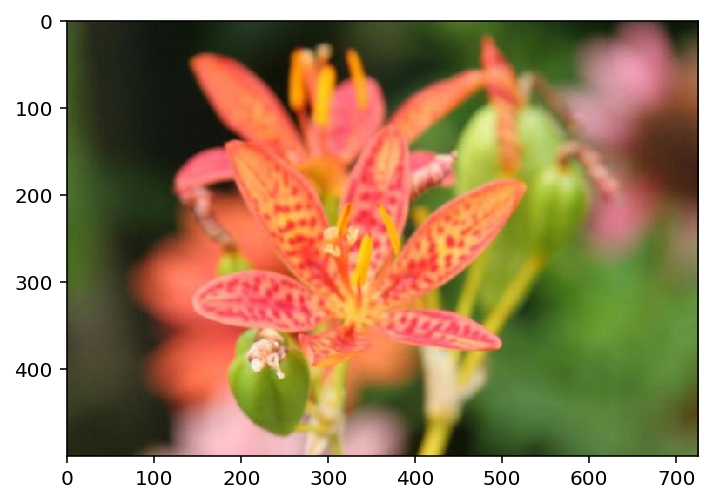

In [54]:
with Image.open('flower_data/valid/102/image_08006.jpg') as image:
    plt.imshow(image)

## Class Prediction

In [55]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [56]:
model.class_to_idx = image_datasets['train'].class_to_idx

In [57]:
def predict2(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # Implement the code to predict the class from an image file
    img = Image.open(image_path)
    img = process_image(img)
    
    # Convert 2D image to 1D vector
    img = np.expand_dims(img, 0)
    
    
    img = torch.from_numpy(img)
    
    model.eval()
    inputs = Variable(img).to(device)
    logits = model.forward(inputs)
    
    ps = F.softmax(logits,dim=1)
    topk = ps.cpu().topk(topk)
    
    return (e.data.numpy().squeeze().tolist() for e in topk)

In [58]:
img_path = 'flower_data/valid/18/image_04252.jpg'
probs, classes = predict2(img_path, model.to(device))
print(probs)
print(classes)
flower_names = [cat_to_name[class_names[e]] for e in classes]
print(flower_names)

[0.9582503437995911, 0.00993520487099886, 0.0027294522151350975, 0.0025336232502013445, 0.0024695610627532005]
[12, 40, 36, 72, 27]
['peruvian lily', 'sword lily', 'sweet pea', 'azalea', 'carnation']


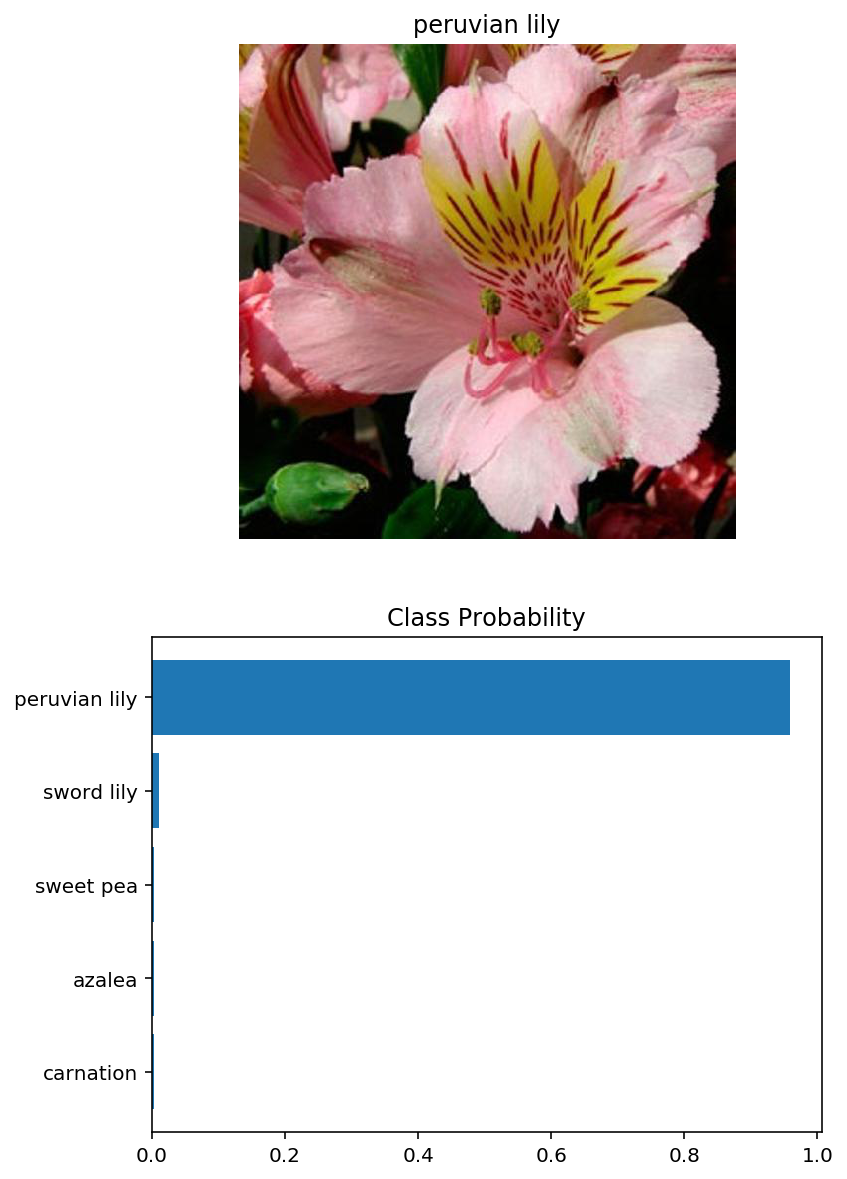

In [59]:
def view_classify(img_path, prob, classes, mapping):
    ''' Function for viewing an image and it's predicted classes.
    '''
    image = Image.open(img_path)

    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
    flower_name = mapping[img_path.split('/')[-2]]
    ax1.set_title(flower_name)
    ax1.imshow(image)
    ax1.axis('off')
    
    y_pos = np.arange(len(prob))
    ax2.barh(y_pos, prob, align='center')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(flower_names)
    ax2.invert_yaxis()  # labels read top-to-bottom
    ax2.set_title('Class Probability')

view_classify(img_path, probs, classes, cat_to_name)